In [1]:
from os.path import join as ospj
from copy import deepcopy

In [2]:
### If using Colab, uncomment the two following lines to mount your Google Drive.

# from google.colab import drive
# drive.mount('/content/drive')


### If using Colab, change the PROJECT_ROOT to where you've uploaded the project.
### E.g. PROJECT_ROOT='/content/drive/MyDrive/TeamX/'
### You may also need to change the `data_dir`, `save_dir`, paths in the `cfgs/exercise_3/` configs.

PROJECT_ROOT='./'
# import sys
# sys.path.append(PROJECT_ROOT)

# import os
# from google.colab import drive
# drive.mount('/content/gdrive')
# os.chdir("/content/gdrive/MyDrive/HLCV/Assignment3")

In [3]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

In [4]:
import torch
if torch.cuda.is_available():
    print("gpu is avalable")
else:
    print('cpu')

gpu is avalable


### Question 4: Use pretrained networks (10 points)

It has become standard practice in computer vision tasks related to images to use a convolutional network pre-trained as the backbone feature extraction network and train new layers on top for the target task. In this question, we will implement such a model. We will use the `VGG_11_bn` network from the `torchvision.models` library as our backbone network. This model has been trained on ImageNet, achieving a top-5 error rate of 10.19%. It consists of 8 convolutional layers followed by adaptive average pooling and fully-connected layers to perform the classification. We will get rid of the average pooling and fully-connected layers from the `VGG_11_bn` model and attach our own fully connected layers to perform the CIFAR-10 classification.

a) Instantiate a pretrained version of the `VGG_11_bn` model with ImageNet pre-trained weights. Add two fully connected layers on top, with Batch Norm and ReLU layers in between them, to build the CIFAR-10 10-class classifier. Note that you will need to set the correct mean and variance in the data-loader, to match the mean and variance the data was normalized with when the `VGG_11_bn` was trained. Train only the newly added layers while disabling gradients for the rest of the network. Each parameter in PyTorch has a required grad flag, which can be turned off to disable gradient computation for it. Get familiar with this gradient control mechanism in PyTorch and train the above model. As a reference point, you will see validation accuracies in the range (61-65%) if implemented correctly. (6 points)

b) We can see that while the ImageNet features are useful, just learning the new layers does not yield better performance than training our own network from scratch. This is due to the domain-shift between the ImageNet dataset (224x224 resolution images) and the CIFAR-10 dataset (32x32 images). To improve the performance we can **fine-tune** `the whole network on the CIFAR-10 dataset, starting from the ImageNet initialization` (set `"fine_tune"` to `true` in `vgg_cifar10.py`). To do this, enable gradient computation to the rest of the network, and update all the model parameters. Additionally train a baseline model where the entire network is trained from scratch, without loading the ImageNet weights (set `"weights"` to `None` in `vgg_cifar10.py`). Compare the two models' training curves, validation, and testing performance in the report. (4 points)


If you're using Pytorch 1, the `weights` argument will not work. In that case, you need to change the `weights` argument to `pretrained=True` or `False`. Feel free to post on Forum if you have any issues.

For both questions, feel free to modify the data augmentation by defining a new preset and referring to it in the config file. However, make sure that in your experiments you always change only one thing at a time (i.e use the same augmentation for both method A and method B if you're comparing them with each other!)

In [4]:
from cfgs.exercise_3 import vgg_cifar10
q4_config = vgg_cifar10.q4_dict


datamodule_class = q4_config['datamodule']
data_args = q4_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file, 
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done 
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}


 By default WandB is enabled in config file for `vgg_cifar10.py`. You can set it to false if you don't want to use it. It's not an essential part of the assignment anyway.  
 We set `wandb = False` in the config file.  

In [5]:
wandb_enabled = q4_config['trainer_config']['wandb']
if wandb_enabled:
    import wandb
    
    # change entity to your wandb username/group name. Also feel free to rename project and run names.
    run = wandb.init(
        project="HLCV-exercise-3", # Change the project name if you wish.
        name=q4_config['name'],
        config=q4_config,
        entity="Curious Puffin", # Replace the curious puffin with your WandB username :)
        dir=PROJECT_ROOT
    )
    run.name = run.name + f'-{run.id}'
    assert run is wandb.run


In [6]:
trainer_class = q4_config['trainer_module']
trainer_vgg = trainer_class(
    config = q4_config, 
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader, 
    eval_loader=valid_data_loader,
)

Warning! Log file ./Logs\CIFAR10_VGG_B2.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_VGG_B2 already exists!Existing checkpoints will be overwritten!


C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


********************
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(512, ep

C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:
train_loss_list, eval_lost_list = trainer_vgg.train()

Train Epoch: 1 Loss: 1.9328: : 100% 45056/45056 [00:30<00:00, 1470.22it/s]
Eval Loss: 1.8370: : 100% 5056/5056 [00:21<00:00, 231.91it/s]


Saved model on eval based on eval_top1 at this step. Previous: -inf, Current: 0.6248022151898734


Train Epoch: 2 Loss: 1.2117: : 100% 45056/45056 [00:28<00:00, 1575.32it/s]
Eval Loss: 1.7048: : 100% 5056/5056 [00:22<00:00, 229.75it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.6248022151898734, Current: 0.6376582278481012


Train Epoch: 3 Loss: 0.9366: : 100% 45056/45056 [00:28<00:00, 1576.17it/s]
Eval Loss: 1.5944: : 100% 5056/5056 [00:22<00:00, 229.08it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.6376582278481012, Current: 0.6457674050632911


Train Epoch: 4 Loss: 1.3624: : 100% 45056/45056 [00:28<00:00, 1558.74it/s]
Eval Loss: 1.5066: : 100% 5056/5056 [00:22<00:00, 227.69it/s]
Train Epoch: 5 Loss: 0.9211: : 100% 45056/45056 [00:28<00:00, 1554.13it/s]
Eval Loss: 1.2503: : 100% 5056/5056 [00:31<00:00, 162.16it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.6457674050632911, Current: 0.6463607594936709


Train Epoch: 6 Loss: 1.7463: : 100% 45056/45056 [00:35<00:00, 1253.99it/s]
Eval Loss: 1.3132: : 100% 5056/5056 [00:27<00:00, 184.17it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.6463607594936709, Current: 0.6568433544303798


Train Epoch: 7 Loss: 0.7761: : 100% 45056/45056 [00:35<00:00, 1285.89it/s]
Eval Loss: 1.9272: : 100% 5056/5056 [00:22<00:00, 222.27it/s] 
Train Epoch: 8 Loss: 2.2089: : 100% 45056/45056 [00:29<00:00, 1510.43it/s]
Eval Loss: 1.3270: : 100% 5056/5056 [00:23<00:00, 219.15it/s] 
Train Epoch: 9 Loss: 1.9967: : 100% 45056/45056 [00:29<00:00, 1502.15it/s]
Eval Loss: 1.8005: : 100% 5056/5056 [00:23<00:00, 216.74it/s] 
Train Epoch: 10 Loss: 0.4169: : 100% 45056/45056 [00:29<00:00, 1536.26it/s]
Eval Loss: 1.7166: : 100% 5056/5056 [00:21<00:00, 231.09it/s]
Train Epoch: 11 Loss: 2.3413: : 100% 45056/45056 [00:28<00:00, 1570.20it/s]
Eval Loss: 1.5826: : 100% 5056/5056 [00:22<00:00, 228.61it/s]


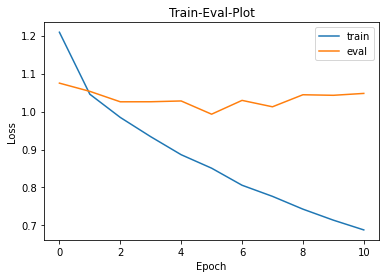

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='train') 
plt.plot(eval_lost_list, label='eval') 
plt.title('Train-Eval-Plot') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend() 
plt.show()

In [13]:
# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_VGG/last_model.pth'

trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

print(result)

if wandb_enabled:
    for metrics, values in result.items():
        wandb.run.summary[f"test_{metrics}"] = values

    # Change the title and message as you wish.
    # Would only work if you have enabled push notifications for your email/slack in wandb account settings.
    # Of course not an essential part of the assignment :)
    wandb.alert(
        title="Training Finished",
        text=f'VGG Training has finished. Test results: {result}', level=wandb.AlertLevel.INFO
    )

    run.finish()

Eval Loss: 1.0270: : 100% 10048/10048 [00:18<00:00, 531.47it/s]

{'loss': 1.1346692203716109, 'top1': 0.6413216560509554, 'top5': 0.963077229299363}


In [5]:
#Q4b
#No freezing weights, but fine tuning them on cifar10 dataset
from cfgs.exercise_3 import vgg_cifar10
q4_config = vgg_cifar10.q4_dict

print(q4_config['name'])


datamodule_class = q4_config['datamodule']
data_args = q4_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file, 
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done 
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it


CIFAR10_VGG_B1
transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}


In [6]:
trainer_class = q4_config['trainer_module']
trainer_vgg = trainer_class(
    config = q4_config, 
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader, 
    eval_loader=valid_data_loader,
)

Warning! Log file ./Logs\CIFAR10_VGG_B1.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_VGG_B1 already exists!Existing checkpoints will be overwritten!


C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


********************
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(512, ep

C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:
train_loss_list_b1, eval_lost_list_b1 = trainer_vgg.train()

Train Epoch: 1 Loss: 0.2678: : 100% 45056/45056 [00:41<00:00, 1098.29it/s]
Eval Loss: 1.3669: : 100% 5056/5056 [00:23<00:00, 219.56it/s] 


Saved model on eval based on eval_top1 at this step. Previous: -inf, Current: 0.8000395569620253


Train Epoch: 2 Loss: 0.9440: : 100% 45056/45056 [00:37<00:00, 1195.74it/s]
Eval Loss: 0.5332: : 100% 5056/5056 [00:21<00:00, 231.02it/s] 
Train Epoch: 3 Loss: 0.3291: : 100% 45056/45056 [00:37<00:00, 1199.29it/s]
Eval Loss: 1.5473: : 100% 5056/5056 [00:22<00:00, 228.82it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.8000395569620253, Current: 0.837618670886076


Train Epoch: 4 Loss: 1.2935: : 100% 45056/45056 [00:37<00:00, 1198.30it/s]
Eval Loss: 1.3599: : 100% 5056/5056 [00:22<00:00, 227.94it/s] 
Train Epoch: 5 Loss: 0.6018: : 100% 45056/45056 [00:38<00:00, 1169.92it/s]
Eval Loss: 1.0699: : 100% 5056/5056 [00:22<00:00, 227.04it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.837618670886076, Current: 0.8613528481012658


Train Epoch: 6 Loss: 0.0076: : 100% 45056/45056 [00:37<00:00, 1196.92it/s]
Eval Loss: 1.8560: : 100% 5056/5056 [00:22<00:00, 228.00it/s] 
Train Epoch: 7 Loss: 0.1731: : 100% 45056/45056 [00:37<00:00, 1201.97it/s]
Eval Loss: 0.8860: : 100% 5056/5056 [00:21<00:00, 231.16it/s] 
Train Epoch: 8 Loss: 0.0080: : 100% 45056/45056 [00:37<00:00, 1206.69it/s]
Eval Loss: 1.4194: : 100% 5056/5056 [00:22<00:00, 224.34it/s] 
Train Epoch: 9 Loss: 0.2324: : 100% 45056/45056 [00:38<00:00, 1179.38it/s]
Eval Loss: 1.7566: : 100% 5056/5056 [00:22<00:00, 223.70it/s] 
Train Epoch: 10 Loss: 0.0171: : 100% 45056/45056 [00:38<00:00, 1170.87it/s]
Eval Loss: 1.3152: : 100% 5056/5056 [00:22<00:00, 223.14it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.8613528481012658, Current: 0.8625395569620253


Train Epoch: 11 Loss: 1.0441: : 100% 45056/45056 [00:37<00:00, 1210.03it/s]
Eval Loss: 1.9431: : 100% 5056/5056 [00:21<00:00, 234.08it/s] 
Train Epoch: 12 Loss: 0.3657: : 100% 45056/45056 [00:36<00:00, 1220.40it/s]
Eval Loss: 1.0995: : 100% 5056/5056 [00:21<00:00, 231.97it/s] 
Train Epoch: 13 Loss: 0.0154: : 100% 45056/45056 [00:37<00:00, 1189.69it/s]
Eval Loss: 1.5588: : 100% 5056/5056 [00:21<00:00, 234.37it/s] 
Train Epoch: 14 Loss: 0.0204: : 100% 45056/45056 [00:37<00:00, 1205.70it/s]
Eval Loss: 1.4716: : 100% 5056/5056 [00:22<00:00, 226.03it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.8625395569620253, Current: 0.8662974683544303


Train Epoch: 15 Loss: 0.0043: : 100% 45056/45056 [00:37<00:00, 1190.06it/s]
Eval Loss: 2.3642: : 100% 5056/5056 [00:22<00:00, 227.32it/s] 


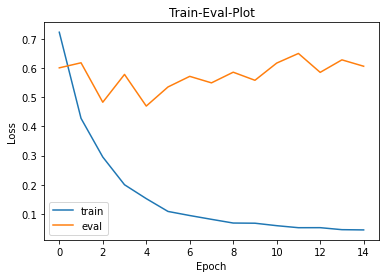

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list_b1, label='train') 
plt.plot(eval_lost_list_b1, label='eval') 
plt.title('Train-Eval-Plot') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend() 
plt.show()

In [11]:
# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_VGG_B1/last_model.pth'

trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

print(result)



Eval Loss: 0.4638: : 100% 10048/10048 [00:18<00:00, 530.74it/s]

{'loss': 0.633177164443739, 'top1': 0.8506170382165605, 'top5': 0.9899482484076433}


In [4]:
#Q4b part2
#Implementing the model from strach and not using the pretrained weights
from cfgs.exercise_3 import vgg_cifar10
q4_config = vgg_cifar10.q4_dict


datamodule_class = q4_config['datamodule']
data_args = q4_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file, 
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done 
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}


In [5]:
trainer_class = q4_config['trainer_module']
trainer_vgg = trainer_class(
    config = q4_config, 
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader, 
    eval_loader=valid_data_loader,
)

Warning! Log file ./Logs\CIFAR10_VGG_B2.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_VGG_B2 already exists!Existing checkpoints will be overwritten!


C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


********************
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
BatchNorm2d(512, ep

C:\Users\pjrad\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
train_loss_list_b2, eval_lost_list_b2 = trainer_vgg.train()

Train Epoch: 1 Loss: 1.0587: : 100% 45056/45056 [02:27<00:00, 305.51it/s]
Eval Loss: 1.4309: : 100% 5056/5056 [00:26<00:00, 188.55it/s] 


Saved model on eval based on eval_top1 at this step. Previous: -inf, Current: 0.6716772151898734


Train Epoch: 2 Loss: 2.6750: : 100% 45056/45056 [01:58<00:00, 379.64it/s]
Eval Loss: 1.2025: : 100% 5056/5056 [00:31<00:00, 159.10it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.6716772151898734, Current: 0.7280458860759493


Train Epoch: 3 Loss: 0.6891: : 100% 45056/45056 [01:56<00:00, 386.27it/s]
Eval Loss: 1.3358: : 100% 5056/5056 [00:31<00:00, 161.10it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.7280458860759493, Current: 0.7616693037974683


Train Epoch: 4 Loss: 0.7222: : 100% 45056/45056 [01:54<00:00, 394.83it/s]
Eval Loss: 1.4116: : 100% 5056/5056 [00:30<00:00, 165.25it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.7616693037974683, Current: 0.7948971518987342


Train Epoch: 5 Loss: 0.3051: : 100% 45056/45056 [01:55<00:00, 388.51it/s]
Eval Loss: 1.2369: : 100% 5056/5056 [00:28<00:00, 174.68it/s] 
Train Epoch: 6 Loss: 0.0106: : 100% 45056/45056 [01:54<00:00, 392.08it/s]
Eval Loss: 1.4062: : 100% 5056/5056 [00:29<00:00, 171.27it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.7948971518987342, Current: 0.8010284810126582


Train Epoch: 7 Loss: 0.8047: : 100% 45056/45056 [01:55<00:00, 388.96it/s]
Eval Loss: 1.7739: : 100% 5056/5056 [00:29<00:00, 171.86it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.8010284810126582, Current: 0.8059731012658228


Train Epoch: 8 Loss: 0.1021: : 100% 45056/45056 [01:56<00:00, 386.73it/s]
Eval Loss: 1.7565: : 100% 5056/5056 [00:28<00:00, 178.21it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.8059731012658228, Current: 0.8105221518987342


Train Epoch: 9 Loss: 0.2474: : 100% 45056/45056 [01:59<00:00, 377.62it/s]
Eval Loss: 1.9871: : 100% 5056/5056 [00:28<00:00, 174.89it/s] 
Train Epoch: 10 Loss: 1.5533: : 100% 45056/45056 [02:10<00:00, 346.15it/s]
Eval Loss: 2.0492: : 100% 5056/5056 [00:29<00:00, 170.56it/s] 


Saved model on eval based on eval_top1 at this step. Previous: 0.8105221518987342, Current: 0.8247626582278481


Train Epoch: 11 Loss: 0.0407: : 100% 45056/45056 [01:56<00:00, 385.29it/s]
Eval Loss: 1.9601: : 100% 5056/5056 [00:29<00:00, 170.30it/s] 
Train Epoch: 12 Loss: 0.2424: : 100% 45056/45056 [01:57<00:00, 384.17it/s]
Eval Loss: 0.7920: : 100% 5056/5056 [00:29<00:00, 173.38it/s] 
Train Epoch: 13 Loss: 0.0375: : 100% 45056/45056 [02:48<00:00, 267.23it/s]
Eval Loss: 1.5303: : 100% 5056/5056 [00:34<00:00, 148.41it/s] 
Train Epoch: 14 Loss: 1.0928: : 100% 45056/45056 [02:31<00:00, 298.27it/s]
Eval Loss: 1.7958: : 100% 5056/5056 [00:35<00:00, 142.06it/s] 
Train Epoch: 15 Loss: 0.0772: : 100% 45056/45056 [00:44<00:00, 1006.53it/s]
Eval Loss: 1.8496: : 100% 5056/5056 [00:23<00:00, 219.20it/s] 


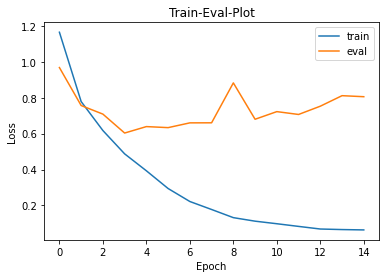

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list_b2, label='train') 
plt.plot(eval_lost_list_b2, label='eval') 
plt.title('Train-Eval-Plot') 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.legend() 
plt.show()

In [10]:
# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_VGG_B2/last_model.pth'

trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

print(result)





Eval Loss: 1.8252: : 100% 10048/10048 [00:19<00:00, 504.55it/s]

{'loss': 0.8993227159141735, 'top1': 0.8046377388535032, 'top5': 0.9856687898089171}


#### Write your report for Q4 in this cell.  
Comparing results on the test set, the fine-tuned pre-trained model achieved the best performance, while the frozen pre-trained model performed the worst. The fine-tuned model's loss started lower than the other two models (due to the pre-trained weights, compared to the model trained from strach) and its training loss decreased faster, dropping below 0.1 by the 8th epoch.  
The model trained from scratch had its loss drop below 0.2 by the 8th epoch, while the frozen pre-trained model's loss remained above 0.7. In terms of evaluation loss, the fine-tuned model again had the lowest loss, while the frozen pre-trained model had a lower evaluation loss than the model trained from scratch.
All in all, the fine-tuned pretrained model has the best performance among the three models.





  

